The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [],
                 'channel': [],
                 'frequency_per_week': [],
                 'phaseshift': []},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [0],
           'index': ['2023-03-01T08:40:00'],
           'slope': [-0.003919854313094806]}}


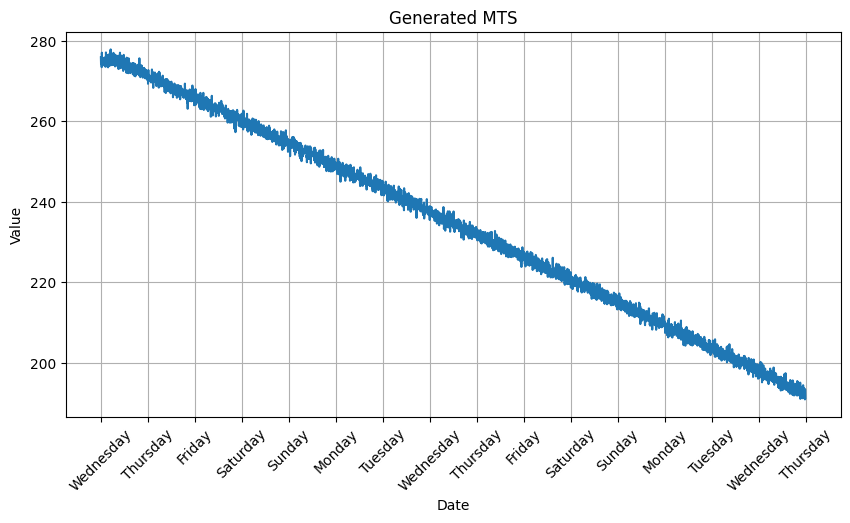

In [8]:
%load_ext autoreload
%autoreload 2
import matplotlib
# matplotlib.use('Agg')
from dataGen import Gen
# from utils import compare, experiment
# from train import slidingWindow, criterion, train, test, objective, train_vae
# from Encoders import LongShort_TCVAE_Encoder, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
# from Decoders import LongShort_TCVAE_Decoder, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
# from vae import VariationalAutoencoder, VQ_MST_VAE, VQ_Quantizer

import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.distributions as D
from torch.utils.data import DataLoader
# import optuna
# from optuna.samplers import TPESampler
# import torchaudio

import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D


import numpy as np
import matplotlib.pyplot as plt
import pprint
# all parameters for generating the time series should be configured in this cell
periode = 15 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 1
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.005,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":0,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()

class VariationalAutoencoder(nn.Module):
    def __init__(self, n_channels, num_layers, latent_dims, v_encoder, v_decoder, v_quantizer,
                 L=30,
                 slope=0.2,
                 first_kernel=None,
                 commit_loss=0.25,
                 modified=True,
                 reduction=False,
                 inits=None
                 ):
        super(VariationalAutoencoder, self).__init__()
        self._n_channels = n_channels
        self._num_layers = num_layers
        self._latent_dims = latent_dims
        self._v_encoder = v_encoder
        self._v_decoder = v_decoder
        self._v_quantizer = v_quantizer
        self._L = L
        self._slope = slope
        self._first_kernel = first_kernel
        self._commit_loss = commit_loss
        self._reduction = reduction
        self._modified = modified
        self.z = None
        if inits == None:
            self._inits = torch.ones(n_channels)
        else:
            self._inits = inits
        print(self._inits)
        if self._modified:
            self._num_embed = self._n_channels * 4 * self._num_layers
        else:
            self._num_embed = self._n_channels * 2
        if self._reduction:
            self._num_embed = self._num_embed // 2
        self.encoder = self._v_encoder(self._n_channels, self._num_layers, self._latent_dims, self._L, self._slope,
                                       self._first_kernel, self._modified, self._reduction)
        self.decoder = self._v_decoder(self._n_channels, self._latent_dims, self._L)
        
    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparametrization_trick(mu, logvar)
        self.z= z.detach()
#         print("Z: ", z.shape)
        rec = self.decoder(z)
#         print("x:", x)
#         print("Rec: ", rec)
        return rec, mu, logvar 

In [9]:
# torch.set_default_tensor_type(torch.cuda.FloatTensor)
class Gen_Decoder(nn.Module):
    def __init__(self, n_channels, latent_dims, L=30):
        super(Gen_Decoder, self).__init__()

        self._n_channels = n_channels
        self._latent_dims = latent_dims
        self._L = L
        self._n_params = 5
        self._complexity = (self._latent_dims - 2) // self._n_params # for each channel: latent dims - 2 for the mean and std 
                                                        # divided by the number of parameters to extract
#         device = 'cuda' if torch.cuda.is_available() else 'cpu'
#         self.mean = torch.empty(self._n_channels)
#         self.logvar = torch.empty(self._n_channels)
#         self.trend_index = torch.empty(self._n_channels, self._complexity)
#         self.trend_slope = torch.empty(self._n_channels, self._complexity)
        
#         self.seasonality_fpw = torch.empty(self._n_channels, self._complexity)
#         self.seasonality_amp = torch.empty(self._n_channels, self._complexity)
#         self.seasonality_phase = torch.empty(self._n_channels, self._complexity)
        
        
        
#         self.params = {
#             "mean":torch.empty(self._n_channels),
#             "logvar":torch.empty(self._n_channels),
#             "trend":{
#                 "index":torch.empty(self._n_channels, self._complexity),
#                 "slope":torch.empty(self._n_channels, self._complexity)
#             },
#             "seasonality":{
#                 "frequency_per_week":torch.empty(self._n_channels, self._complexity),
#                 "amplitude":torch.empty(self._n_channels, self._complexity),
#                 "phaseshift":torch.empty(self._n_channels, self._complexity)
#             }
#         } 
        



    def reparametrization_trick(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def extract_params(self, codebook):
#         codebook = codebook.squeeze(0)
#         print("Codebook in the gen Decoder",codebook.shape)
        for channel in range(self._n_channels):
#             print("channel loop index", channel)
#             print("Codbook Values", codebook, codebook.T, codebook.T[0,channel])
#             self.mean[channel] = codebook.T[0, channel]
#             self.logvar[channel] = codebook.T[1,channel]
            mean = codebook.T[0, channel]
            logvar = codebook.T[1,channel]
#             print("exracted mean", mean.shape, mean)
#             print("exracted logvar", logvar.shape, logvar)
#             self.params["mean"][channel] = codebook.T[0, channel]
#             self.params["logvar"][channel] = 1.0 # torch.clamp(codebook.T[1, channel], max=2)
            for i in range(self._complexity):
                n_effect = i*self._n_params
                trend_index       = codebook.T[2 + n_effect, channel]
                trend_slope       = codebook.T[3 + n_effect, channel]
                seasonality_fpw   = codebook.T[4 + n_effect, channel]
                seasonality_amp   = codebook.T[5 + n_effect, channel]
                seasonality_phase = codebook.T[6 + n_effect, channel]
#             print("exracted trend_index", trend_index.shape, trend_index)
#             print("exracted trend_slope", trend_slope.shape, trend_slope)
#             print("exracted seasonality_fpw", seasonality_fpw.shape, seasonality_fpw)
#             print("exracted seasonality_amp", seasonality_amp.shape, seasonality_amp)
#             print("exracted seasonality_phase", seasonality_phase.shape, seasonality_phase)
                
#                 self.params["trend"]["index"][channel, i]                    = codebook.T[2 + n_effect, channel]
#                 self.params["trend"]["slope"][channel, i]                    = codebook.T[3 + n_effect, channel]
#                 self.params["seasonality"]["frequency_per_week"][channel, i] = codebook.T[4 + n_effect, channel]
#                 self.params["seasonality"]["amplitude"][channel, i]          = codebook.T[5 + n_effect, channel]
#                 self.params["seasonality"]["phaseshift"][channel, i]         = codebook.T[6 + n_effect, channel]
        return mean, logvar, trend_index, trend_slope, seasonality_fpw, seasonality_amp, seasonality_phase
    
    def gen_rec(self, mean, logvar):
#         print("extracted mean", self.mean.shape)
#         print("extracted std", self.logvar)
        means = mean.unsqueeze(1).expand(-1, self._L)
#         print("mean after expand and squeeze", means.shape)
#         std = torch.exp(0.5 * self.logvar)
        logvars = logvar.unsqueeze(1).expand(-1, self._L)
#         means = self.params["mean"].unsqueeze(1).expand(-1, self._L).requires_grad_()
#         std = torch.exp(0.5 * self.params["logvar"])
#         stds = std.unsqueeze(1).expand(-1, self._L).requires_grad_()
#         print(means.shape)
#         print(stds.shape)
        rec = self.reparametrization_trick(means, logvars)
#         print("shape of generated rec",rec.shape)
#         print(rec)
        return rec
    
    def add_trend(self, rec, trend_index, trend_slope):    
        # generate the trends
        trends = torch.zeros_like(rec)
#         print("trend shape", trends.shape)
#         print("trend_index shape", trend_index.shape)
#         print("trend_slope shape", trend_slope.shape)
        for channel in range(self._n_channels):
            indexes = trend_index.unsqueeze(1)[channel, :]
#             print("indexes", indexes.shape)
            slopes = trend_slope.unsqueeze(1)[channel, :]
#             print("slopes", slopes.shape)
            print(self._L)
            print(indexes)
            mask = torch.arange(self._L).unsqueeze(1) >= indexes.unsqueeze(0)
#             print("mask", mask.T.shape)
            trends[channel:] = mask.T.sum(dim=1).float() * slopes
#             print("generated trend", trends.shape)
        rec = rec + trends
#         print("rec after trend", rec.shape)
#             if trend_type == "linear":
#                 trends[ch, idx:] += np.linspace(0, slopes[channel] * self.step * shifted, shifted)
#             elif trend_type == "quadratic":
#                 trends[ch, idx:] += np.linspace(0, slopes[channel] * self.step * shifted, shifted)**2
#             elif trend_type == "mixed":
#                 trends[ch, idx:] += np.linspace(0, slopes[channel] * self.step * shifted, shifted)**((channel%2)+1)

        # add it to the channels
        return rec
            

    def forward(self, cb):
        mean, logvar, trend_index, trend_slope, seasonality_fpw, seasonality_amp, seasonality_phase = self.extract_params(cb)
        rec = self.gen_rec(mean, logvar)
        rec = self.add_trend(rec, trend_index, trend_slope)
        rec = rec.unsqueeze(0)
#         print("shape of generated rec after unsqueeze", rec.shape)
        return rec


In [11]:
x = torch.FloatTensor(x)
n = x.shape[1]
torch.autograd.set_detect_anomaly(True)
train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

### Init Model
latent_dims = 7 # 6 # 17
L= 3455# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'


v = VariationalAutoencoder(n_channels,
                            num_layers =  3,#4, #3
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = Gen_Decoder, #LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = 0,
                            first_kernel = 60, #11, #20
                            commit_loss = 0.25,
                            modified=False,
                            reduction = True,
                            inits=x[:,0])
# v = VQ_MST_VAE(n_channels = n_channels,
#                             num_layers =  3,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = LongShort_TCVAE_Decoder, #LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             v_quantizer = VQ_Quantizer,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 60, #11, #20
#                             commit_loss = 0.25,
#                             modified=False,
#                             reduction = True,
#                             inits=None) #10 5


v = v.to(device)
opt = optim.Adam(v.parameters(), lr = 0.001043529186448577) # 0.005043529186448577 0.006819850049647945

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(slidingWindow(train_, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=22,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=22,
                        shuffle = False
                        )


tensor([275.8749])


In [12]:
for epoch in range(1, 100):
    train(v, train_data, criterion, opt, device, epoch, VQ = False)

/tmp/ipykernel_23370/347989260.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  mean = codebook.T[0, channel]


3455
tensor([0.1165], device='cuda:0', grad_fn=<SliceBackward0>)


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [360]:
def compare(dataset, model, VQ=True):
    model.eval()
    rec = []
    x = []
    T = dataset.dataset.data.shape[1]- L
    idx = 0
    _mu_rec, _logvar_rec = [], []
    _mu, _logvar = [], []
#     _mu, _logvar = (torch.empty((n_channels * 2, T, L)) for _ in range(2))
#     _mu_rec, _logvar_rec = (torch.empty((T, n_channels)) for _ in range(2))
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            bs = data.shape[0]
            if VQ:
                x_rec, loss, mu, logvar, z = model(data, v)
            else:
                x_rec, mu, logvar = model(data)
            z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)
#             print(mu.shape)

            x.extend((data)[:,:,:].detach().numpy())
            rec.extend(((x_rec)[:,:,:]).detach().numpy())
#             _mu_rec.extend((mu_rec*v)[:,:,0].detach().numpy())
#             _logvar_rec.extend(((torch.exp(0.5 * logvar_rec))*v)[:,:,0].detach().numpy())
            
#             _mu.extend((mu*v)[:,:,0].detach().numpy())
#             _logvar.extend(((torch.exp(0.5 * logvar))*v)[:,:,0].detach().numpy())
#             _mu[idx: idx + bs, :, :] = mu
#             _mu_rec[idx: idx + bs, :] = (mu_rec*v)[:,:,0]
#     print(np.array(rec).shape)
#     _mu = np.array(_mu)
#     _logvar = np.array(_logvar)
    
    rec = np.array(rec).squeeze(0).T
    x = np.array(x).squeeze(0).T
    print(x.shape)
    print(rec)
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
    ax = axs#[0]
    ax.plot(rec, "r-")
    ax.plot(x, "b-", alpha=0.2)
#     ax.plot(_mu_rec)
#     ax.plot(params["mu"].T[:_mu.shape[0],:])
    ax.grid()
    
#     ax_std = axs[1]
#     ax_std.plot(_logvar_rec, "r")
#     ax_std.plot(params["cov"][0,:,:T].T, "b")
#     ax_std.grid()
    
#     ax_enc = axs[2]
#     for (i,l) in enumerate(_mu.T):        
#         ax_enc.plot(l.T, alpha = (0.2 + 0.1*i))
# #     ax_enc.plot(_mu, alpha = 0.2)
#     ax_enc.grid()
    
#     ax_log = axs[3]
#     for (i,l) in enumerate(_logvar.T):        
#         ax_log.plot(l.T, alpha = (0.2 + 0.1*i))
#     ax_log.grid()
    
    # Setting legend
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
#     for ax in axs:
        # ax.set_title('Reconstruction of Train Data')
    ax.set_title('Prediction of Test (unseen) Data')
    ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    
    
    # Axes labels
#     ax_std.set_xlabel('Time')
#     ax.set_ylabel('Values')
#     ax_std.set_ylabel('Values')
#     plt.ylim(-100,500)
    plt.grid(True)
    fig.tight_layout()
    plt.show()

In [362]:
a = torch.randn(1,2).to(x)
# v.quantizer._embedding.weight.detach()[4] = a
v.cpu()
compare(train_data, v, VQ=False)
v.to(device)

3455
tensor([0.6128], device='cpu')


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [302]:
def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook.T)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    
    return ax_heatmap
    

array([[[320.44104  ,  -4.2680726]]], dtype=float32)

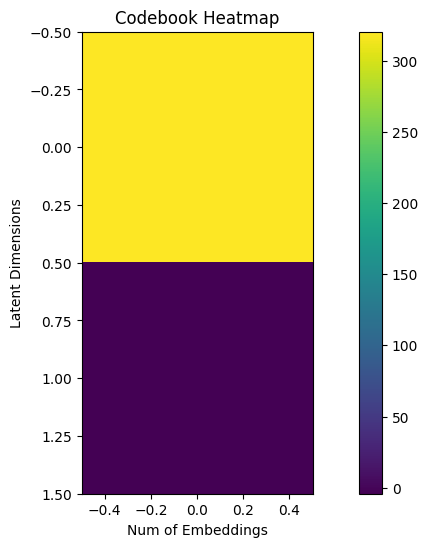

In [303]:
from matplotlib.figure import Figure
codebook = v.z.cpu().detach().numpy()
heatmap = create_heatmap(codebook)
codebook